## Important: must use python 3.11.x

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import dropbox

from sklearn.tree import export_text
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost import XGBClassifier

from patsy import dmatrices
import numpy as np
import pandas as pd

2024-09-23 11:36:33.012950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = pd.read_excel("/Users/jacopobinati/Desktop/damo_DeepLNeural256/dataset/dataset_with_MACRO 1.xlsx")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dataset.head(5)

,Organization Name,IPO Status,Company Type,Number of Employees,Last Funding Type,Last Funding Date,Founded Date,Founded Date Precision,Operating Status,Number of Founders,Number of Funding Rounds,Last Funding Amount (in USD),Last Equity Funding Amount (in USD),Total Equity Funding Amount (in USD),Total Funding Amount (in USD),Top 5 Investors,Number of Investors,Headquarters Regions,Industry Groups,Industries,Headquarters Location,Last Funding Year,Founded Year,Main Industry,Industry Name,Status__Private,CompanyType__For Profit,CompanyType__Non-profit,NumberEmployees__1-10,NumberEmployees__10001+,NumberEmployees__1001-5000,NumberEmployees__101-250,NumberEmployees__11-50,NumberEmployees__251-500,NumberEmployees__5001-10000,NumberEmployees__501-1000,NumberEmployees__51-100,FundingType__Angel,FundingType__Convertible Note,FundingType__Corporate Round,FundingType__Debt Financing,FundingType__Equity Crowdfunding,FundingType__Grant,FundingType__Initial Coin Offering,FundingType__Non-equity Assistance,FundingType__Post-IPO Debt,FundingType__Post-IPO Equity,FundingType__Post-IPO Secondary,FundingType__Pre-Seed,FundingType__Private Equity,FundingType__Product Crowdfunding,FundingType__Secondary Market,FundingType__Seed,FundingType__Series A,FundingType__Series B,FundingType__Series C,FundingType__Series D,FundingType__Series E,FundingType__Series F,FundingType__Series G,FundingType__Series H,FundingType__Series I,FundingType__Series J,FundingType__Undisclosed,FundingType__Venture - Series Unknown,Industry_Aerospace/Defense,Industry_Air Transport,Industry_Apparel,Industry_Auto & Truck,Industry_Auto Parts,Industry_Bank (Money Center),Industry_Banks (Regional),Industry_Beverage (Soft),Industry_Brokerage & Investment Banking,Industry_Building Materials,Industry_Business & Consumer Services,Industry_Chemical (Basic),Industry_Chemical (Diversified),Industry_Chemical (Specialty),Industry_Coal & Related Energy,Industry_Computer Services,Industry_Computers/Peripherals,Industry_Diversified,Industry_Drugs (Biotechnology),Industry_Drugs (Pharmaceutical),Industry_Education,Industry_Electrical Equipment,Industry_Electronics (Consumer & Office),Industry_Electronics (General),Industry_Engineering/Construction,Industry_Entertainment,Industry_Environmental & Waste Services,Industry_Farming/Agriculture,Industry_Financial Svcs. (Non-bank & Insurance),Industry_Food Processing,Industry_Food Wholesalers,Industry_Green & Renewable Energy,Industry_Healthcare Support Services,Industry_Heathcare Information and Technology,Industry_Homebuilding,Industry_Hotel/Gaming,Industry_Household Products,Industry_Information Services,Industry_Insurance (General),Industry_Investments & Asset Management,Industry_Machinery,Industry_Power,Industry_Publishing & Newspapers,Industry_Real Estate (General/Diversified),Industry_Real Estate (Operations & Services),Industry_Recreation,Industry_Restaurant/Dining,Industry_Retail (Automotive),Industry_Retail (General),Industry_Semiconductor,Industry_Software (Entertainment),Industry_Software (Internet),Industry_Software (System & Application),Industry_Telecom. Equipment,Industry_Telecom. Services,Industry_Transportation,Industry_Transportation (Railroads),Macro Region,Region_Asia-Pacific,Region_EMEA,Region_Emerging Markets,Region_North America,LastFundingType__Angel,LastFundingType__Convertible Note,LastFundingType__Corporate Round,LastFundingType__Debt Financing,LastFundingType__Equity Crowdfunding,LastFundingType__Grant,LastFundingType__Initial Coin Offering,LastFundingType__Non-equity Assistance,LastFundingType__Post-IPO Debt,LastFundingType__Post-IPO Equity,LastFundingType__Post-IPO Secondary,LastFundingType__Pre-Seed,LastFundingType__Private Equity,LastFundingType__Product Crowdfunding,LastFundingType__Secondary Market,LastFundingType__Seed,LastFundingType__Series A,LastFundingType__Series B,LastFundingType__Series C,LastFundingType__Series D,LastFundingType__Series E,LastFundingType__Series F,LastFundingType__Series G,LastFundingType

## Metrics into a Composite Score
Step-by-Step Computation:
Normalization of Metrics:

I normalized each financial metric to a range between 0 and 1. Normalization helps in standardizing different scales across metrics, making them comparable.
 
This scales each metric so that its minimum value becomes 0 and its maximum value becomes 1.

Composite Industry Factor Calculation:

I created a composite score by combining the normalized metrics using predefined weights:
- EV/Sales: 20%
- ROE: 30%
- Expected Growth (Next 5 Years): 30%
- Forward PE: 10%
- Percentage of Money Losing Firms: Inverted to reflect risk (10%)
### Combining Metrics into a Composite Score:
The composite score is calculated using the weighted sum of the normalized metrics. The formula used is:
Industry Factor = 0.2 × Normalized EV/Sales + 0.3 × Normalized ROE + 0.3 × Normalized Expected Growth + 0.1 × (1 − Normalized Money Losing Firms) + 0.1 × Normalized Forward PE


This results in a single score representing the overall favorability of each industry.

In [5]:
dataset["Industry Groups"].unique()

array(['Information Technology, Real Estate, Software, Sustainability',
       'Energy, Financial Services, Lending and Investments, Natural Resources, Software, Sustainability, Transportation',
       'Blockchain and Cryptocurrency, Education, Internet Services, Software',
       ...,
       'Education, Information Technology, Professional Services, Software',
       'Advertising, Commerce and Shopping, Gaming, Sales and Marketing, Software',
       'Consumer Electronics, Consumer Goods, Hardware, Software'],
      dtype=object)

In [6]:
## use of the function is:
# recall the function compute_variable(Industry_Groups, Founded_Date, IPO_Status, CompanyType__For_Profit, Number_of_Funding_Rounds, 
#                                      EV_Sales, EV_EBITDA, Forward_PE, Expected_growth_next_5_years)


#### now all we need to do before running the models is to get only float, bool, int variables

In [7]:
columns_to_drop = [
    "Organization Name",
    "IPO Status",
    "Company Type",
    "Number of Employees",
    "Last Funding Type",
    "Last Funding Date",
    "Founded Date",
    "Founded Date Precision",
    "Operating Status",
    "Top 5 Investors",
    "Headquarters Location",
    "Industry Groups",
    "Industries",
    "Headquarters Regions",
    "Main Industry",
    "Industry Name",
    "Macro Region",
    "PEG Ratio",
    "Aggregate Mkt Cap/ Net Income (all firms)"

]
dataset = dataset.drop(columns=columns_to_drop, axis=1)

#### Need to be dropped all the variables which are not dummies, integers or float

In [8]:
dataset

,Number of Founders,Number of Funding Rounds,Last Funding Amount (in USD),Last Equity Funding Amount (in USD),Total Equity Funding Amount (in USD),Total Funding Amount (in USD),Number of Investors,Last Funding Year,Founded Year,Status__Private,CompanyType__For Profit,CompanyType__Non-profit,NumberEmployees__1-10,NumberEmployees__10001+,NumberEmployees__1001-5000,NumberEmployees__101-250,NumberEmployees__11-50,NumberEmployees__251-500,NumberEmployees__5001-10000,NumberEmployees__501-1000,NumberEmployees__51-100,FundingType__Angel,FundingType__Convertible Note,FundingType__Corporate Round,FundingType__Debt Financing,FundingType__Equity Crowdfunding,FundingType__Grant,FundingType__Initial Coin Offering,FundingType__Non-equity Assistance,FundingType__Post-IPO Debt,FundingType__Post-IPO Equity,FundingType__Post-IPO Secondary,FundingType__Pre-Seed,FundingType__Private Equity,FundingType__Product Crowdfunding,FundingType__Secondary Market,FundingType__Seed,FundingType__Series A,FundingType__Series B,FundingType__Series C,FundingType__Series D,FundingType__Series E,FundingType__Series F,FundingType__Series G,FundingType__Series H,FundingType__Series I,FundingType__Series J,FundingType__Undisclosed,FundingType__Venture - Series Unknown,Industry_Aerospace/Defense,Industry_Air Transport,Industry_Apparel,Industry_Auto & Truck,Industry_Auto Parts,Industry_Bank (Money Center),Industry_Banks (Regional),Industry_Beverage (Soft),Industry_Brokerage & Investment Banking,Industry_Building Materials,Industry_Business & Consumer Services,Industry_Chemical (Basic),Industry_Chemical (Diversified),Industry_Chemical (Specialty),Industry_Coal & Related Energy,Industry_Computer Services,Industry_Computers/Peripherals,Industry_Diversified,Industry_Drugs (Biotechnology),Industry_Drugs (Pharmaceutical),Industry_Education,Industry_Electrical Equipment,Industry_Electronics (Consumer & Office),Industry_Electronics (General),Industry_Engineering/Construction,Industry_Entertainment,Industry_Environmental & Waste Services,Industry_Farming/Agriculture,Industry_Financial Svcs. (Non-bank & Insurance),Industry_Food Processing,Industry_Food Wholesalers,Industry_Green & Renewable Energy,Industry_Healthcare Support Services,Industry_Heathcare Information and Technology,Industry_Homebuilding,Industry_Hotel/Gaming,Industry_Household Products,Industry_Information Services,Industry_Insurance (General),Industry_Investments & Asset Management,Industry_Machinery,Industry_Power,Industry_Publishing & Newspapers,Industry_Real Estate (General/Diversified),Industry_Real Estate (Operations & Services),Industry_Recreation,Industry_Restaurant/Dining,Industry_Retail (Automotive),Industry_Retail (General),Industry_Semiconductor,Industry_Software (Entertainment),Industry_Software (Internet),Industry_Software (System & Application),Industry_Telecom. Equipment,Industry_Telecom. Services,Industry_Transportation,Industry_Transportation (Railroads),Region_Asia-Pacific,Region_EMEA,Region_Emerging Markets,Region_North America,LastFundingType__Angel,LastFundingType__Convertible Note,LastFundingType__Corporate Round,LastFundingType__Debt Financing,LastFundingType__Equity Crowdfunding,LastFundingType__Grant,LastFundingType__Initial Coin Offering,LastFundingType__Non-equity Assistance,LastFundingType__Post-IPO Debt,LastFundingType__Post-IPO Equity,LastFundingType__Post-IPO Secondary,LastFundingType__Pre-Seed,LastFundingType__Private Equity,LastFundingType__Product Crowdfunding,LastFundingType__Secondary Market,LastFundingType__Seed,LastFundingType__Series A,LastFundingType__Series B,LastFundingType__Series C,LastFundingType__Series D,LastFundingType__Series E,LastFundingType__Series F,LastFundingType__Series G,LastFundingType__Series H,LastFundingType__Series I,LastFundingType__Series J,LastFundingType__Undisclosed,LastFundingType__Venture - Series Unknown,Price/Sales,Net Margin,EV/Sales,Pre-tax Operating Margin,PBV,ROE,EV/ Invested Capital,ROIC,EV/EBITDAR&D,EV/EBITDA,EV/EBIT,EV/EBIT (1-t),EV/EBITD

In [9]:
dataset["EV/EBIT (1-t)5"].describe()

count    16257.000000
mean        24.942589
std        223.519423
min      -6081.431016
25%         20.572607
50%         31.184155
75%         43.765672
max        197.446017
Name: EV/EBIT (1-t)5, dtype: float64

In [10]:
print(dataset.isna().sum().to_string())

Number of Founders                                                     0
Number of Funding Rounds                                               0
Last Funding Amount (in USD)                                           0
Last Equity Funding Amount (in USD)                                    0
Total Equity Funding Amount (in USD)                                   0
Total Funding Amount (in USD)                                          0
Number of Investors                                                    0
Last Funding Year                                                      0
Founded Year                                                           0
Status__Private                                                        0
CompanyType__For Profit                                                0
CompanyType__Non-profit                                                0
NumberEmployees__1-10                                                  0
NumberEmployees__10001+                            

In [11]:
dataset["FundingXround"] = dataset["Total Funding Amount (in USD)"] / dataset["Number of Funding Rounds"]

In [12]:
dataset.dropna(inplace=True)

In [13]:
from sklearn.preprocessing import MinMaxScaler
columns_to_normalize = [
    "EV/Sales",
    "ROE",
    "Expected growth - next 5 years",
    "Forward PE",
    "% of Money Losing firms (Trailing)"
]

scaler = MinMaxScaler()

dataset["Norm Total Funding"] = scaler.fit_transform(dataset[["Total Funding Amount (in USD)"]])
dataset["Norm EV/Sales"] = scaler.fit_transform(dataset[["EV/Sales"]])
dataset["Norm ROE"] = scaler.fit_transform(dataset[["ROE"]])
dataset["Norm Expected growth 5 years"] = scaler.fit_transform(dataset[["Expected growth - next 5 years"]])
dataset["Norm Forward PE"] = scaler.fit_transform(dataset[["Forward PE"]])
dataset["Norm % of Money Losing firms (Trailing)"] = scaler.fit_transform(dataset[["% of Money Losing firms (Trailing)"]])

# Define weights for the normalized columns
weights = {
    "Norm EV/Sales": 0.2,
    "Norm ROE": 0.2,
    "Norm Expected growth 5 years": 0.25,
    "Norm Forward PE": 0.1,
    "Norm % of Money Losing firms (Trailing)": 0.1,
    "Norm Total Funding": 0.15
}

# Calculate the weighted sum for normalized_valuation
dataset["normalized_valuation"] = sum(dataset[col] * weight for col, weight in weights.items())

# Display summary statistics
summary_statistics = dataset[list(weights.keys())].describe()

summary_statistics

,Norm EV/Sales,Norm ROE,Norm Expected growth 5 years,Norm Forward PE,Norm % of Money Losing firms (Trailing),Norm Total Funding
count,15629.000000,15629.000000,15629.000000,15629.000000,15629.000000,15629.000000
mean,0.178147,0.195646,0.432178,0.311164,0.588508,0.010504
std,0.173212,0.124552,0.127338,0.227584,0.269112,0.045650
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.069170,0.133908,0.351719,0.106517,0.338770,0.000176
50%,0.135798,0.181684,0.449374,0.256247,0.584729,0.001263
75%,0.260928,0.240148,0.499308,0.488199,0.889610,0.006517
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
dataset["normalized_valuation"] = scaler.fit_transform(dataset[["normalized_valuation"]])

In [15]:
dataset["normalized_valuation"].describe()

count    15629.000000
mean         0.431038
std          0.198215
min          0.000000
25%          0.295070
50%          0.431150
75%          0.518792
max          1.000000
Name: normalized_valuation, dtype: float64

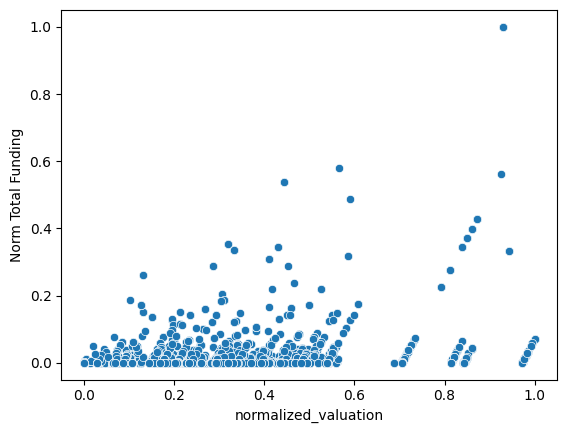

In [16]:
import seaborn as sns
sns.scatterplot(data=dataset, y="Norm Total Funding", x="normalized_valuation")
plt.savefig("/Users/jacopobinati/Desktop/damo_DeepLNeural256/visualization/scatterplot.png")

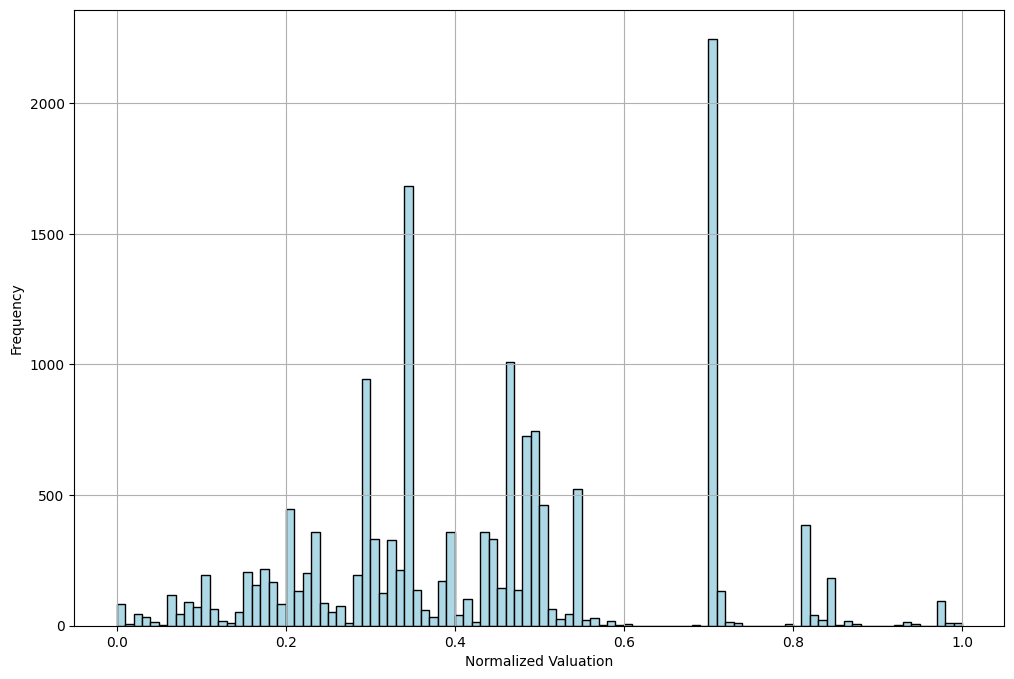

In [17]:
plt.figure(figsize=(12,8))
plt.hist(dataset["normalized_valuation"], bins=100, color="lightblue", edgecolor="black")
plt.grid()
plt.xlabel("Normalized Valuation")
plt.ylabel("Frequency")
plt.show()

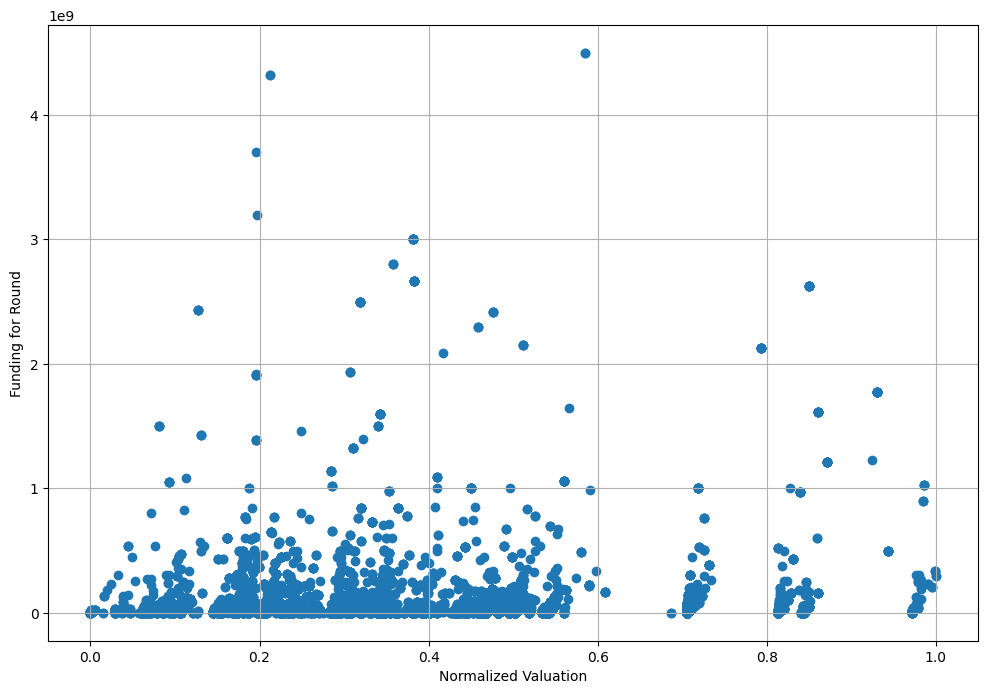

In [18]:
plt.figure(figsize=(12,8))
plt.scatter(dataset["normalized_valuation"], dataset["FundingXround"])
plt.xlabel("Normalized Valuation")
plt.ylabel("Funding for Round")
plt.grid()
plt.show()

In [19]:
print(dataset.isna().sum().to_string())

Number of Founders                                                  0
Number of Funding Rounds                                            0
Last Funding Amount (in USD)                                        0
Last Equity Funding Amount (in USD)                                 0
Total Equity Funding Amount (in USD)                                0
Total Funding Amount (in USD)                                       0
Number of Investors                                                 0
Last Funding Year                                                   0
Founded Year                                                        0
Status__Private                                                     0
CompanyType__For Profit                                             0
CompanyType__Non-profit                                             0
NumberEmployees__1-10                                               0
NumberEmployees__10001+                                             0
NumberEmployees__100

In [20]:
dataset.to_excel("/Users/jacopobinati/Desktop/damo_DeepLNeural256/dataset/learning_dataset.xlsx", index=False)
dataset.to_excel("/Users/jacopobinati/Desktop/damo_DeepLNeural256/dataset/dataset_with_MACRO 2.xlsx", index=False)

# new session

In [21]:
X = dataset.drop('normalized_valuation', axis=1)
y = dataset['normalized_valuation']

In [22]:
bdt = GradientBoostingRegressor()
bdt.fit(X, y)
print(bdt.feature_importances_)
print(bdt.score(X, y))


[6.41536409e-06 4.04030382e-06 9.72731429e-05 6.08673579e-04
 4.04385062e-04 3.89655396e-03 3.03278345e-06 9.84157360e-08
 7.24996665e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.16171908e-09 4.73341136e-10
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.52223216e-06 0.00000000e+00 0.00000000e+00 5.32237071e-06
 5.76373554e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.15485089e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.40724969e-05 0.00000000e+00 1.45194842e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.21024648e-06 0.00000000e+00 0.00000000e+00
 1.30538041e-05 0.00000000e+00 8.89217602e-05 0.00000000e+00
 7.00682064e-06 0.000000

<Axes: title={'center': 'Feature Importance'}, xlabel='Feature'>

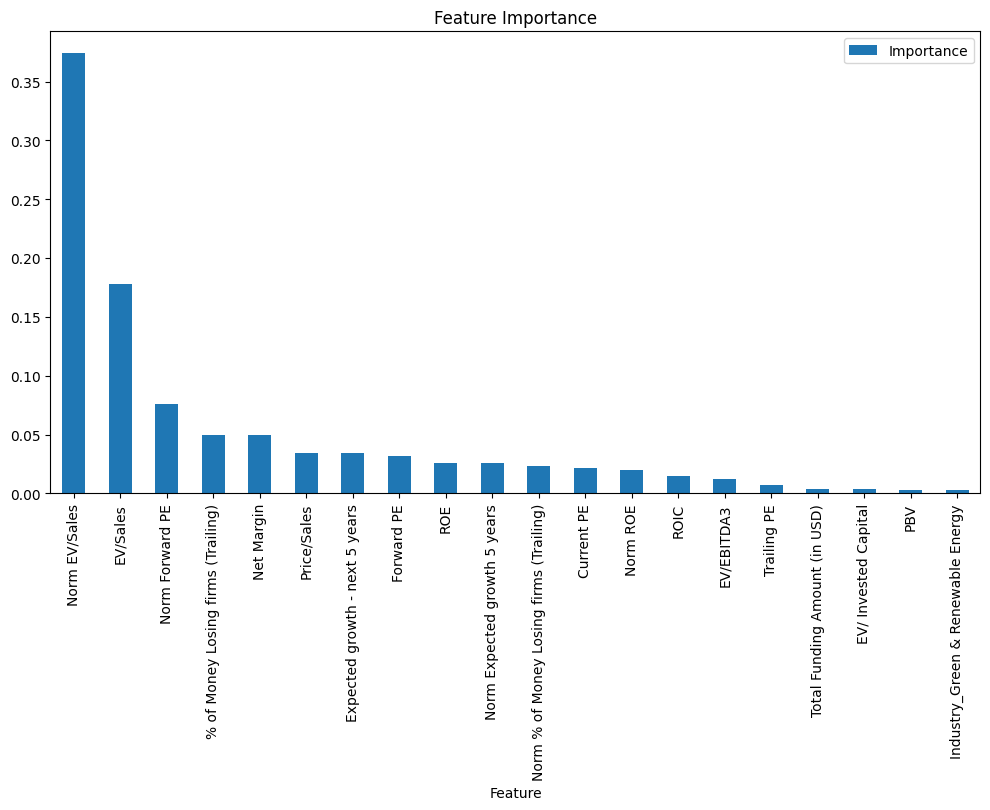

In [23]:
feature_names = dataset.columns
feature_names = feature_names.drop('normalized_valuation')  

feature_importances = bdt.feature_importances_

df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
df_sorted = df.sort_values(by='Importance', ascending=False)

df_sorted[:20].plot(x='Feature', y='Importance', kind='bar', title='Feature Importance', figsize=(12, 6))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
dataset

,Number of Founders,Number of Funding Rounds,Last Funding Amount (in USD),Last Equity Funding Amount (in USD),Total Equity Funding Amount (in USD),Total Funding Amount (in USD),Number of Investors,Last Funding Year,Founded Year,Status__Private,CompanyType__For Profit,CompanyType__Non-profit,NumberEmployees__1-10,NumberEmployees__10001+,NumberEmployees__1001-5000,NumberEmployees__101-250,NumberEmployees__11-50,NumberEmployees__251-500,NumberEmployees__5001-10000,NumberEmployees__501-1000,NumberEmployees__51-100,FundingType__Angel,FundingType__Convertible Note,FundingType__Corporate Round,FundingType__Debt Financing,FundingType__Equity Crowdfunding,FundingType__Grant,FundingType__Initial Coin Offering,FundingType__Non-equity Assistance,FundingType__Post-IPO Debt,FundingType__Post-IPO Equity,FundingType__Post-IPO Secondary,FundingType__Pre-Seed,FundingType__Private Equity,FundingType__Product Crowdfunding,FundingType__Secondary Market,FundingType__Seed,FundingType__Series A,FundingType__Series B,FundingType__Series C,FundingType__Series D,FundingType__Series E,FundingType__Series F,FundingType__Series G,FundingType__Series H,FundingType__Series I,FundingType__Series J,FundingType__Undisclosed,FundingType__Venture - Series Unknown,Industry_Aerospace/Defense,Industry_Air Transport,Industry_Apparel,Industry_Auto & Truck,Industry_Auto Parts,Industry_Bank (Money Center),Industry_Banks (Regional),Industry_Beverage (Soft),Industry_Brokerage & Investment Banking,Industry_Building Materials,Industry_Business & Consumer Services,Industry_Chemical (Basic),Industry_Chemical (Diversified),Industry_Chemical (Specialty),Industry_Coal & Related Energy,Industry_Computer Services,Industry_Computers/Peripherals,Industry_Diversified,Industry_Drugs (Biotechnology),Industry_Drugs (Pharmaceutical),Industry_Education,Industry_Electrical Equipment,Industry_Electronics (Consumer & Office),Industry_Electronics (General),Industry_Engineering/Construction,Industry_Entertainment,Industry_Environmental & Waste Services,Industry_Farming/Agriculture,Industry_Financial Svcs. (Non-bank & Insurance),Industry_Food Processing,Industry_Food Wholesalers,Industry_Green & Renewable Energy,Industry_Healthcare Support Services,Industry_Heathcare Information and Technology,Industry_Homebuilding,Industry_Hotel/Gaming,Industry_Household Products,Industry_Information Services,Industry_Insurance (General),Industry_Investments & Asset Management,Industry_Machinery,Industry_Power,Industry_Publishing & Newspapers,Industry_Real Estate (General/Diversified),Industry_Real Estate (Operations & Services),Industry_Recreation,Industry_Restaurant/Dining,Industry_Retail (Automotive),Industry_Retail (General),Industry_Semiconductor,Industry_Software (Entertainment),Industry_Software (Internet),Industry_Software (System & Application),Industry_Telecom. Equipment,Industry_Telecom. Services,Industry_Transportation,Industry_Transportation (Railroads),Region_Asia-Pacific,Region_EMEA,Region_Emerging Markets,Region_North America,LastFundingType__Angel,LastFundingType__Convertible Note,LastFundingType__Corporate Round,LastFundingType__Debt Financing,LastFundingType__Equity Crowdfunding,LastFundingType__Grant,LastFundingType__Initial Coin Offering,LastFundingType__Non-equity Assistance,LastFundingType__Post-IPO Debt,LastFundingType__Post-IPO Equity,LastFundingType__Post-IPO Secondary,LastFundingType__Pre-Seed,LastFundingType__Private Equity,LastFundingType__Product Crowdfunding,LastFundingType__Secondary Market,LastFundingType__Seed,LastFundingType__Series A,LastFundingType__Series B,LastFundingType__Series C,LastFundingType__Series D,LastFundingType__Series E,LastFundingType__Series F,LastFundingType__Series G,LastFundingType__Series H,LastFundingType__Series I,LastFundingType__Series J,LastFundingType__Undisclosed,LastFundingType__Venture - Series Unknown,Price/Sales,Net Margin,EV/Sales,Pre-tax Operating Margin,PBV,ROE,EV/ Invested Capital,ROIC,EV/EBITDAR&D,EV/EBITDA,EV/EBIT,EV/EBIT (1-t),EV/EBITD

## Pycaret

In [2]:
!pip install pycaret

  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyod-2.0.2.tar.gz (165 kB)
  Preparing metadata (setup.py) ... done
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached category_encoders-2.6.3-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached yellowbrick-1.5-py3-none-any.whl.metadata (7.7 kB)
  Using cached kaleido-0.2.1-py2.py3-none-macosx_10_11_x86_64.whl.metadata (15 kB)
  Using cached schemdraw-0.

'''python 
pip install scikit-learn==0.24.2
pip install pycaret
'''

In [3]:
import pycaret as pc
from pycaret.regression import *

s = setup(dataset, 
            target='normalized_valuation', session_id=123)

NameError: name 'dataset' is not defined

In [61]:
best = compare_models()

results_df = pull()

results_df = results_df.round(4)

In [62]:
results_df

""


## XG Boost Classifier

In [86]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'colsample_bytree': [0.3, 1.0],
    'subsample': [0.6, 1.0],
    'min_child_weight': [1, 5]
}

# Initialize the XGBClassifier
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.7s[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.7s



/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   5.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   5.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   5.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   5.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   5.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   5.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   5.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.3s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   6.4s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   6.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   3.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   3.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   3.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   3.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   3.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   2.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   2.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   3.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   3.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   3.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for thes

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   4.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   1.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for thes

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   6.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   7.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   7.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   7.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   7.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   3.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=  11.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=  12.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   7.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   7.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   6.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   7.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   6.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   6.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=  11.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=  11.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=  10.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   9.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=  11.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=  11.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=  11.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=  11.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   4.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   5.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   5.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=  15.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=  15.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   6.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   6.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   6.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   6.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   6.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   6.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   3.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   3.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.4s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   1.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   4.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   3.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   4.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for thes

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.8s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for thes

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   3.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   2.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   5.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   5.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   5.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   6.1s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.6s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.5s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   6.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.7s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   3.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   3.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   2.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   5.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total time=   7.0s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   7.9s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/ver

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   8.3s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   9.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   7.2s


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/utils/_param_

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=1.0; total time=   7.0s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='logloss', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=N...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'min_child_weight': [1, 5], 'n_estimators': [100, 300],
                         'subsample': [0.6, 1.0]},
             scoring='accuracy', verbose=2)

In [87]:
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test_scaled)


# Calculate accuracy
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Features and Metrics
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

metrics = pd.DataFrame({
    "Metrics": ["Mean Squared Error", "R^2 Score", "Mean Absolute Error"],
    "Values": [mse, r2, mae]
})
metrics

Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}


,Metrics,Values
0,Mean Squared Error,0.007975
1,R^2 Score,0.790976
2,Mean Absolute Error,0.072436


In [88]:
features.head(10)

,Feature,Importance
162,Norm EV/Sales,0.132950
140,EV/Sales,0.113126
141,Pre-tax Operating Margin,0.074674
139,Net Margin,0.054096
157,Forward PE,0.048731
148,EV/EBIT,0.048238
165,Norm Forward PE,0.047403
152,EV/EBIT4,0.042766
138,Price/Sales,0.040541
147,EV/EBITDA,0.038880


/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacopobinati/.pyenv/versions/3.10.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters

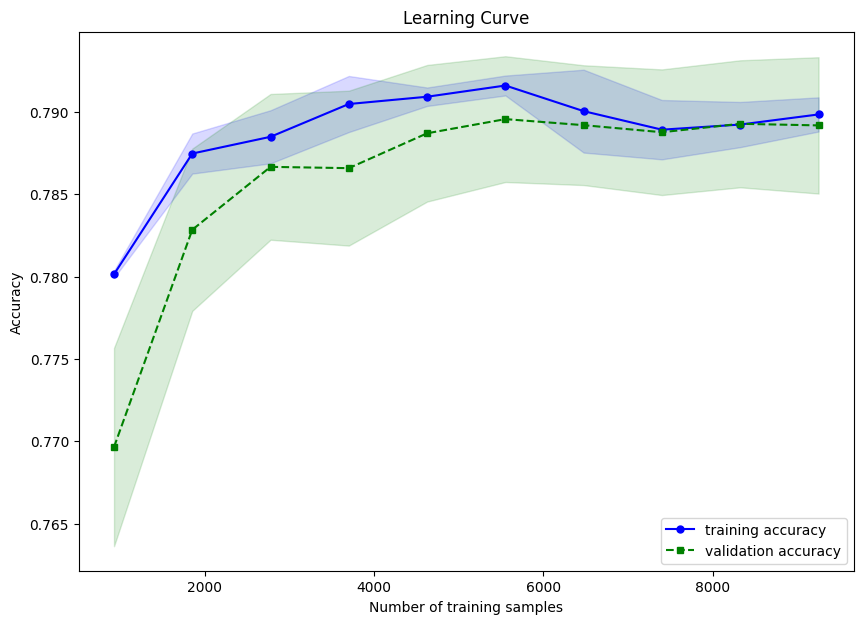

<Figure size 640x480 with 0 Axes>

In [89]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb, X_train_scaled, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,7))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.savefig("/Users/jacopobinati/Desktop/damo_DeepLNeural256/learning_curve.png")


## Simple Deep Neural Network

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# the model
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Epoch 1/300
313/313 [==============================] - 9s 8ms/step - loss: 0.0696 - val_loss: 0.0139
Epoch 2/300
313/313 [==============================] - 3s 8ms/step - loss: 0.0151 - val_loss: 0.0056
Epoch 3/300
313/313 [==============================] - 2s 5ms/step - loss: 0.0089 - val_loss: 0.0039
Epoch 4/300
313/313 [==============================] - 2s 5ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 5/300
313/313 [==============================] - 1s 4ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 6/300
313/313 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 7/300
313/313 [==============================] - 2s 7ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 8/300
313/313 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 9/300
313/313 [==============================] - 3s 9ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/300
313/313 [==============================] - 2s 6ms/step - loss: 0.0021 - val_lo

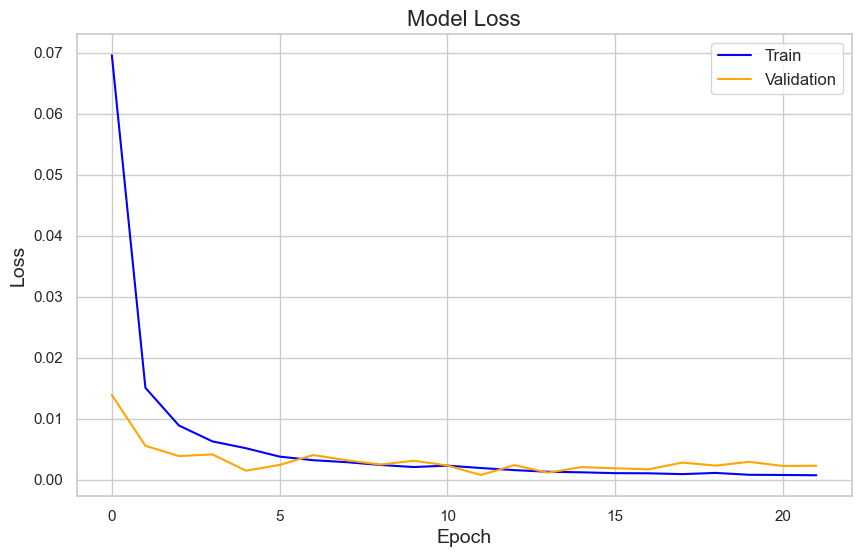

<Figure size 640x480 with 0 Axes>

In [91]:
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=history.history['loss'], label='Train', color='blue')
sns.lineplot(data=history.history['val_loss'], label='Validation', color='orange')
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.show()
plt.savefig("/Users/jacopobinati/Desktop/damo_DeepLNeural256/model_loss.png")